# Identyfikacja Automatów Komórkowych

Wykład: https://github.com/houp/ca-class/blob/main/slides/lecture8.pdf

### Importy

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## zad.15
Zaimplementuj prosty algorytm identyfikacji CA na podstawie obserwacji. \
Założenia:
- Dana jest obserwacja, która nie zawiera tzw. "dziur czasowych" (temporal gaps). Innymi słowy każde dwa kolejne wiersze obserwacji odpowiadają dwum kolejnym krokom czasu CA.
- Obserwacja może zawierać dziury (spatial gaps) w pojedynczych komórkach. Są one oznaczone przez “stan” o wartości -1.
- Opcja łatwiejsza: zakładamy, że promień sąsiedztwa jest znany i podany jako argument funkcji.
- Opcja trudniejsza: zakładamy, że nie jest znany promień sąsiedztwa i trzeba znaleźć automat o najmniejszym promieniu.
- Opcja bardziej trudniejsza: zakładamy, że w obserwacji może pojawić się szum - tzn. zaobserwowane stany niektórych komórek mogą być błędne (zaobserwowano 1 a było 0 i vice versa).

Podpowiedzi:
- Nie ma dziur czasowych, więc nie trzeba robić algorytmu ewolucyjnego!
- Wystarczy przejrzeć całą obserwację i spróbować "odczyta" regułę.
- Trzeba się zastanowić co zrobić w przypadku gdy pewnych konfiguracji sąsiedztw w ogóle nie zaobserwowano. Co wtedy? 
- Warto napisać sobie własny test do tego algorytmu na podstawie stworzonej na wcześniejszych zajęciach generujących diagramy czaso-przestrzenne. Losujemy 
regułę. Generujemy diagram czasoprzestrzenny. Odpalamy nasz algorytm identyfikacji i sprawdzamy czy wykrył tą samą regułę od której wystartowaliśmy.

In [2]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)

def plot_space_time(spacetime):
    cmap = colors.ListedColormap(['gray', 'white', 'black'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(5, 5))
    plt.imshow(spacetime, cmap=cmap, norm=norm, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [6]:
lut = eca_get_lut(random.randrange(0,256))
print(lut)
initial_conf = np.random.randint(0,2,25)

[0 0 1 1 1 0 0 0]


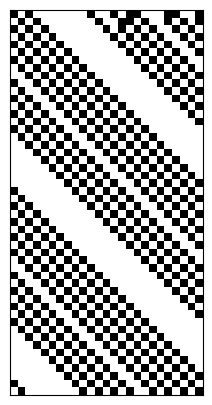

In [7]:
spacetime = eca_evolve_spacetime(lut, initial_conf, 50)
plot_space_time(spacetime)

In [8]:
spacetime

array([[1, 0, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 1]])

Funkcja dodająca dziury (spatial gaps) w komórkach:

In [9]:
def generate_observation(spacetime: np.ndarray, percent: float) -> np.ndarray:
    spacetime_copy = spacetime.copy()
    total_cells = spacetime_copy.size
    num_gaps = int(total_cells * percent)
    
    for _ in range(num_gaps):
        row = np.random.randint(1, spacetime_copy.shape[0])
        col = np.random.randint(spacetime_copy.shape[1])
        spacetime_copy[row, col] = -1
    
    return spacetime_copy


In [10]:
spacetime.size*0.06

75.0

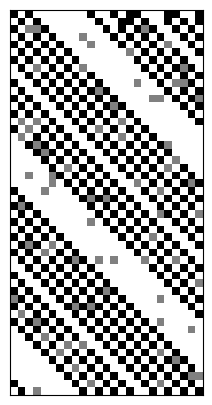

In [11]:
spacetime2 = generate_observation(spacetime, 0.06)
plot_space_time(spacetime2)

---

In [ ]:
# def generate_observation(rule: np.ndarray, ...):
#     ...
#     return

# # ---
# rules = [eca_get_lut(rule) for rule in range(256)]
# for rule in rules:
#     generate_observation(rule, ...)

In [40]:
def ca_identify(spacetime: np.ndarray) -> np.ndarray:
    lut = np.full(8, 0, dtype=np.int8)
    
    # for t in range(spacetime.shape[0]-1):
    #     for x in range(spacetime.shape[1]):
    #         if spacetime[t+1, x] != -1 and neighborhoods[t, x] != -1 and spacetime[t, x-1] and neighborhoods[t, x+1]:
    #             lut[spacetime[t, x-1:x+1]] = spacetime[t+1, x]

    rules = [eca_get_lut(rule) for rule in range(256)]
    
    
    return lut


In [48]:
x=1
spacetime[0, x-1:x+2]

array([1, 0, 1])

In [41]:
print(lut)
print(ca_identify(spacetime))

[0 0 1 1 1 0 0 0]
[0 1 2 3 4 5 6]
[0 0 0 0 0 0 0 0]
0
6
[0 0 0 1 1 1 0 0]


In [42]:
print(lut)
print(ca_identify(spacetime2))

[0 0 1 1 1 0 0 0]
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[0 0 0 0 0 0 0 0]
0
6
[0 0 0 1 1 1 0 0]


In [ ]:
# def ca_identify(spacetime: np.ndarray) -> np.ndarray:
#     lut = np.zeros((2, 2, 2), dtype=int)
#     T, X = spacetime.shape
#     for t in range(T-1):
#         for x in range(X):
#             # Uwzględniamy zapętlanie wierszy
#             left = spacetime[t, (x-1)%X]
#             center = spacetime[t, x]
#             right = spacetime[t, (x+1)%X]
#             next_val = spacetime[t+1, x]
#             lut[left, center, right] = next_val
#     return lut
